# Phase 2: Konstruksi Graf & Ekstraksi Fitur Jaringan

**Tujuan:** Pada tahap ini, kita akan mengubah data interaksi tabular dari `master_df` menjadi sebuah model **jaringan (graf)**. Ini memungkinkan kita untuk menganalisis struktur hubungan antar akun dan mengekstrak fitur-fitur kuat berbasis topologi jaringan (SNA) yang tidak akan terlihat dari data biasa.

**Langkah-langkah yang akan dilakukan:**
1.  **Install & Import:** Memasang dan memuat library khusus untuk analisis jaringan.
2.  **Load Cleaned Data:** Memuat `master_dataset_cleaned.csv` dari Phase 1.
3.  **Build Interaction Graph:** Membuat objek graf `networkx` dari interaksi `reply`.
4.  **Calculate Centrality Metrics:** Menghitung metrik pengaruh dan konektivitas seperti PageRank, Betweenness, In-Degree, dan Out-Degree.
5.  **Perform Community Detection:** Menggunakan Algoritma Louvain untuk menemukan kelompok-kelompok akun yang saling berinteraksi secara padat.
6.  **Create Final Feature DataFrame:** Menggabungkan semua fitur jaringan ke dalam satu DataFrame baru yang siap untuk tahap selanjutnya.



### 2.1. Install & Import Requirements for Network Analysis

In [ ]:
import pandas as pd
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

--- 2.1. Requirements Installed & Libraries Imported ---
Semua library untuk analisis jaringan telah siap.


### 2.2. Load The Master Dataset

In [ ]:
try:
    master_df = pd.read_csv('master_dataset_cleaned.csv')
    print("✅ 'master_dataset_cleaned.csv' berhasil dimuat.")
    print(f"Shape: {master_df.shape}")
except FileNotFoundError:
    print("❌ ERROR: File 'master_dataset_cleaned.csv' tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan notebook Phase 1 terlebih dahulu.")
    master_df = pd.DataFrame()


✅ 'master_dataset_cleaned.csv' berhasil dimuat.
Shape: (788, 7)


### 2.3. Build Interaction Graph

Kita akan membuat sebuah **Directed Graph (DiGraph)** menggunakan `networkx`. Dalam graf ini:
- **Node (Titik):** Setiap `username` unik.
- **Edge (Garis Berarah):** Sebuah garis dari `username` (sumber) ke `reply_to_user` (target), merepresentasikan sebuah interaksi balasan.


In [ ]:
if not master_df.empty:
    G = nx.DiGraph()

    # Mengambil data interaksi yang valid (di mana 'reply_to_user' tidak kosong)
    interaction_df = master_df.dropna(subset=['reply_to_user'])

    # Menambahkan edges dari DataFrame
    for index, row in interaction_df.iterrows():
        source = row['username']
        target = row['reply_to_user']
        # Networkx secara otomatis akan menambahkan node jika belum ada
        G.add_edge(source, target)

    print("--- 2.3. Graph Construction Completed ---")
    print(f"Jumlah Node (akun unik): {G.number_of_nodes()}")
    print(f"Jumlah Edge (interaksi reply): {G.number_of_edges()}")
else:
    print("DataFrame kosong, langkah ini dilewati.")

--- 2.3. Graph Construction Completed ---
Jumlah Node (akun unik): 165
Jumlah Edge (interaksi reply): 102


### 2.4. Calculate Centrality Metrics

Sekarang kita akan menghitung metrik-metrik SNA untuk mengukur "pentingnya" setiap node dalam jaringan.
- **In-Degree & Out-Degree:** Mengukur aktivitas dasar (berapa banyak di-reply vs. me-reply).
- **PageRank:** Mengukur pengaruh sebuah akun (seberapa penting akun yang berinteraksi dengannya).
- **Betweenness Centrality:** Mengukur peran akun sebagai "jembatan" antar komunitas. Nilai 0 menunjukkan akun terisolasi dalam grupnya.


In [16]:
if 'G' in locals() and G.number_of_nodes() > 0:
    # 1. Hitung In-Degree dan Out-Degree
    in_degree_dict = dict(G.in_degree())
    out_degree_dict = dict(G.out_degree())
    
    # 2. Hitung PageRank
    pagerank_dict = nx.pagerank(G, alpha=0.85) # alpha adalah parameter standar
    
    # 3. Hitung Betweenness Centrality
    betweenness_dict = nx.betweenness_centrality(G)
    
    print("--- 2.4. Centrality Metrics Calculated ---")
    print("Metrik In-Degree, Out-Degree, PageRank, dan Betweenness berhasil dihitung.")
else:
    print("Graf kosong atau belum dibuat, langkah ini dilewati.")

--- 2.4. Centrality Metrics Calculated ---
Metrik In-Degree, Out-Degree, PageRank, dan Betweenness berhasil dihitung.


### 2.5. Perform Community Detection

Kita akan menggunakan **Algoritma Louvain** untuk mendeteksi komunitas atau "cluster" akun yang sering berinteraksi satu sama lain. Algoritma ini bekerja pada graf yang tidak berarah, jadi kita perlu mengkonversi graf kita sementara.


In [17]:
if 'G' in locals() and G.number_of_nodes() > 0:
    # Konversi ke undirected graph untuk deteksi komunitas
    G_undirected = G.to_undirected()
    
    # Menjalankan algoritma Louvain
    partition_dict = community_louvain.best_partition(G_undirected)
    
    print("--- 2.5. Community Detection Completed ---")
    print(f"Ditemukan {len(set(partition_dict.values()))} komunitas dalam jaringan.")
else:
    print("Graf kosong atau belum dibuat, langkah ini dilewati.")

--- 2.5. Community Detection Completed ---
Ditemukan 65 komunitas dalam jaringan.


### 2.6. Create Final Network Features DataFrame

Langkah terakhir di Phase 2 adalah menggabungkan semua fitur yang telah kita ekstrak ke dalam satu DataFrame yang rapi. DataFrame ini akan berisi daftar semua akun unik beserta skor SNA dan label komunitasnya.


In [18]:
if 'G' in locals() and G.number_of_nodes() > 0:
    # Membuat DataFrame dari semua node unik di graf
    df_nodes = pd.DataFrame(G.nodes(), columns=['username'])
    
    # Memetakan (mapping) setiap metrik dari dictionary ke kolom DataFrame
    df_nodes['pagerank'] = df_nodes['username'].map(pagerank_dict)
    df_nodes['betweenness'] = df_nodes['username'].map(betweenness_dict)
    df_nodes['in_degree'] = df_nodes['username'].map(in_degree_dict)
    df_nodes['out_degree'] = df_nodes['username'].map(out_degree_dict)
    df_nodes['community'] = df_nodes['username'].map(partition_dict)
    
    # Mengisi nilai NaN dengan 0 jika ada
    df_nodes.fillna(0, inplace=True)
    
    # Menampilkan hasil akhir
    print("\n--- ✅ PHASE 2 COMPLETED ---")
    print("Output: DataFrame dengan fitur-fitur jaringan (SNA) per akun.")
    
    # Menampilkan tabel dengan urutan berdasarkan PageRank (pengaruh tertinggi)
    display(df_nodes.sort_values(by='pagerank', ascending=False).head(20))
    
    # Menyimpan hasil ke file CSV untuk digunakan di Phase 3
    df_nodes.to_csv('network_features.csv', index=False)
    print("\n✅ Fitur jaringan berhasil disimpan ke 'network_features.csv'")
    
else:
    print("\n--- ❌ PHASE 2 FAILED ---")
    print("Tidak ada interaksi reply yang ditemukan dalam dataset, sehingga tidak ada fitur jaringan yang bisa dibuat.")



--- ✅ PHASE 2 COMPLETED ---
Output: DataFrame dengan fitur-fitur jaringan (SNA) per akun.


,username,pagerank,betweenness,in_degree,out_degree,community
1,txtdrimedia,0.029477,0.000000,8,0,28
33,rasjawa,0.014169,0.000000,2,0,15
50,salam4jari,0.014169,0.000000,2,0,57
132,fmuchtaar_,0.011975,0.000037,1,2,55
41,ARSIPAJA,0.011882,0.000000,3,0,28
82,tanyakanrl,0.011178,0.000000,2,0,37
6,barengwarga,0.011178,0.000000,2,0,2
17,detikcom,0.011178,0.000000,2,0,7
133,fasya_bercakap,0.009217,0.000000,1,1,55
150,haikarrll85,0.009217,0.000000,1,0,55



✅ Fitur jaringan berhasil disimpan ke 'network_features.csv'


### 2.7. Visualisasi Hasil Analisis Jaringan

Untuk lebih memahami karakteristik jaringan yang telah kita bangun, mari kita buat beberapa visualisasi kunci.


--- Visualisasi 1: Distribusi Metrik SNA ---


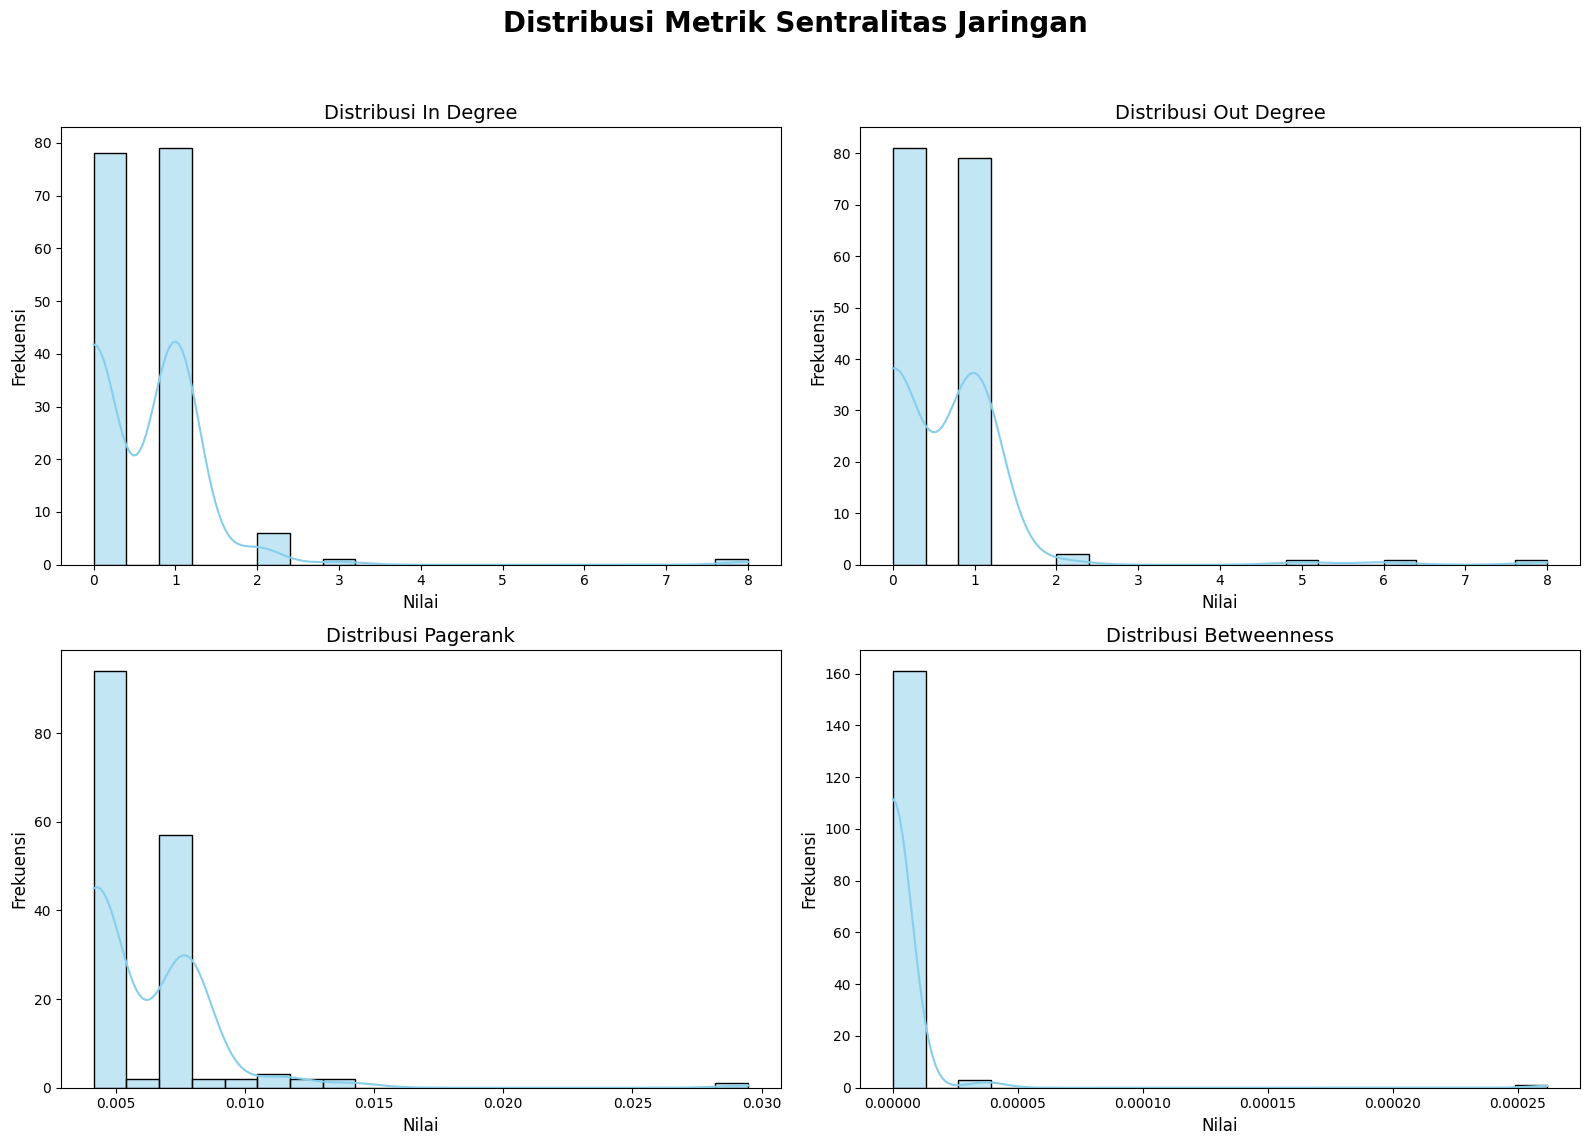

In [19]:
if 'df_nodes' in locals() and not df_nodes.empty:
    print("--- Visualisasi 1: Distribusi Metrik SNA ---")
    
    # Filter out metrics with no variation to avoid plotting empty graphs
    plot_metrics = []
    for col in ['in_degree', 'out_degree', 'pagerank', 'betweenness']:
        if df_nodes[col].nunique() > 1: # Only plot if there is more than one unique value
            plot_metrics.append(col)

    if not plot_metrics:
        print("Metrik SNA tidak memiliki variasi, plot distribusi dilewati.")
    else:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Distribusi Metrik Sentralitas Jaringan', fontsize=20, fontweight='bold')
        
        # Flatten axes for easy iteration
        axes = axes.flatten()

        for i, metric in enumerate(plot_metrics):
            sns.histplot(df_nodes[metric], kde=True, ax=axes[i], bins=20, color='skyblue')
            axes[i].set_title(f'Distribusi {metric.replace("_", " ").title()}', fontsize=14)
            axes[i].set_xlabel('Nilai', fontsize=12)
            axes[i].set_ylabel('Frekuensi', fontsize=12)
        
        # Hide any unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)
            
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

Visualisasi 2: Akun Paling Berpengaruh (Top 10 by PageRank)


--- Visualisasi 2: Top 10 Akun Paling Berpengaruh (by PageRank) ---


/tmp/ipykernel_225712/142511371.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='pagerank', y='username', data=top_10_pagerank, palette='viridis')


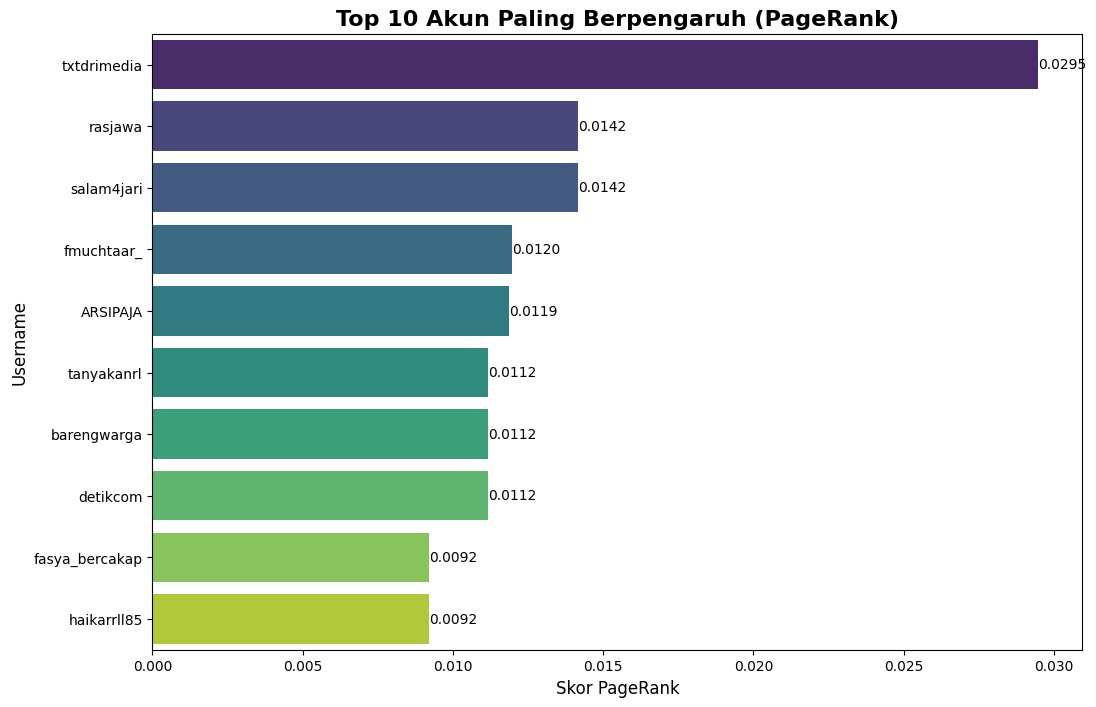

In [20]:
if 'df_nodes' in locals() and not df_nodes.empty and df_nodes['pagerank'].sum() > 0:
    print("\n--- Visualisasi 2: Top 10 Akun Paling Berpengaruh (by PageRank) ---")
    
    top_10_pagerank = df_nodes.sort_values('pagerank', ascending=False).head(10)
    
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='pagerank', y='username', data=top_10_pagerank, palette='viridis')
    
    ax.set_title('Top 10 Akun Paling Berpengaruh (PageRank)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Skor PageRank', fontsize=12)
    ax.set_ylabel('Username', fontsize=12)
    
    # Menambahkan label angka
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', fontsize=10)
        
    plt.show()

Visualisasi 3: Peta Graf Jaringan


--- Visualisasi 3: Peta Graf Jaringan Interaksi ---


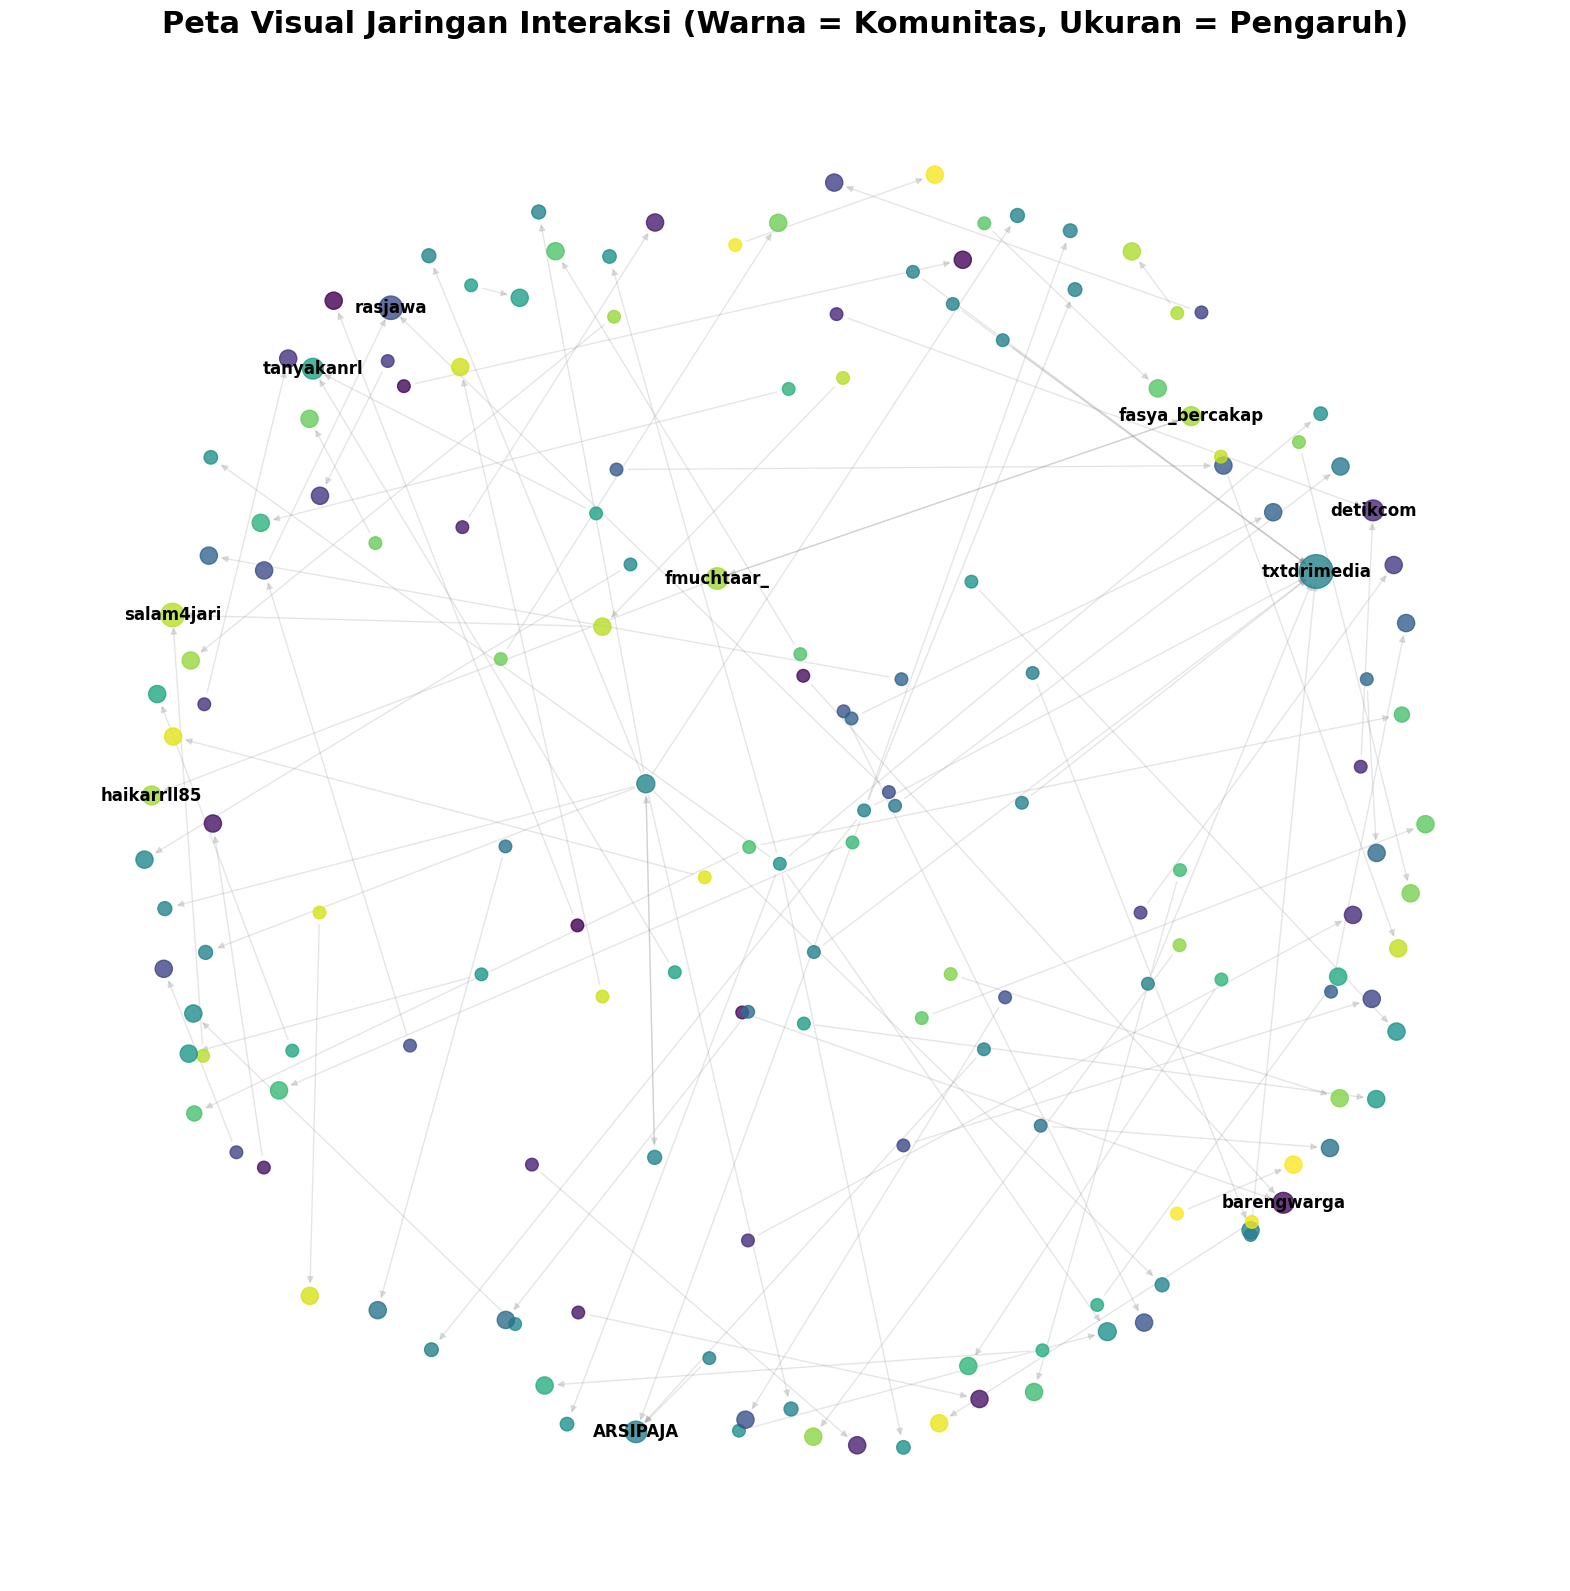

In [21]:
if 'G' in locals() and G.number_of_nodes() > 0:
    print("\n--- Visualisasi 3: Peta Graf Jaringan Interaksi ---")
    
    plt.figure(figsize=(20, 20))
    
    # Menggunakan spring layout untuk penempatan node yang lebih baik
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
    
    # Menentukan warna node berdasarkan komunitas
    node_colors = [partition_dict[node] for node in G.nodes()]
    
    # Menentukan ukuran node berdasarkan PageRank
    node_sizes = [pagerank_dict[node] * 20000 for node in G.nodes()]
    
    # Menggambar jaringan
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, cmap=plt.cm.viridis, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='gray')
    
    # Menambahkan label hanya untuk node paling berpengaruh agar tidak tumpang tindih
    top_nodes = df_nodes.sort_values('pagerank', ascending=False).head(10)['username'].tolist()
    labels = {node: node for node in G.nodes() if node in top_nodes}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_color='black', font_weight='bold')
    
    plt.title('Peta Visual Jaringan Interaksi (Warna = Komunitas, Ukuran = Pengaruh)', fontsize=22, fontweight='bold')
    plt.box(False)
    plt.show()